In [24]:
import os
import sys 
sys.path.append('../../utilities/')
import data_utils, evaluation_utils
sys.path.append('../../src')
from dataset_class import dataset
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from hmmlearn import hmm

signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
K562_dataset = dataset('K562', 'hg19', 100000, '',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/K562/hg19/Hi-C/res100000',
                 signals_names, '../../data/K562/hg19/genomic-assays/bin_100000/', 
                  '../../data/K562/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
K562_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/K562_100000_bins.txt')
#K562_dataset.generate_signals_and_bin_files()

In [2]:
gene_expression_path = '../../data/K562/hg19/gene_expression/K562_genes_RPKM.txt'
RT_path = '../../data/K562/hg19/RT/six_phase/six_phases.txt'

In [3]:
RT_df = pd.read_csv(RT_path, sep = '\t', header = None)
RT_df.columns = ['chr_name', 'pos', 'G1', 'S1', 'S2', 'S3', 'S4', 'G2']
RT_df['pos'] = (RT_df['pos']/100000).astype(int)
RT_df = RT_df.groupby(['chr_name', 'pos'])[['G1', 'S1', 'S2', 'S3', 'S4', 'G2']].mean().reset_index()
bins = pd.read_csv('../../data/valid_bins/hg19/K562_100000_bins.txt', sep = '\t', header = None)
bins.columns = ['chr_name', 'start', 'end', 'index']
bins['pos'] = (bins['start']/100000).astype(int)
bins = bins[['chr_name', 'pos']]
RT_df = pd.merge(bins, RT_df, on = ['chr_name','pos'])

In [29]:
#structural_df = K562_dataset.read_line_embedding('../../data/K562/hg19/res100000_datasets/embeddings/sci/sci_d{8}_s{100}_o{2}.txt', 8, 0)
#structural_signals = np.array(structural_df.loc[:,['emb{}'.format(e) for e in np.arange(1,9)]])
structural_signals_path = "../../data/K562/hg19/res100000_datasets/structural_signals.txt"
structural_signals = np.loadtxt(structural_signals_path)

functional_signals_path = "../../data/K562/hg19/res100000_datasets/signals.txt"
functional_signals = np.loadtxt(functional_signals_path)

combined_signals = np.concatenate([functional_signals, structural_signals], axis = 1)

TSA_signals = K562_dataset.valid_bins_df.copy()
Lamin_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/LaminA_TSA-seq.bedgraph', sep = "\t", header = None)
Lamin_df.columns = ['chr_name', 'start', 'end', 'LaminA']
TSA_signals = TSA_signals.merge(Lamin_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)
SON_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/SON_TSA-seq.bedgraph', sep = "\t", header = None)
SON_df.columns = ['chr_name', 'start', 'end', 'SON']
TSA_signals = pd.merge(TSA_signals, SON_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)

signals_df = pd.DataFrame(np.concatenate([np.array(TSA_signals[['LaminA', 'SON']]), functional_signals], axis = 1))
signals_df.columns = ['LaminA', 'SON'] + signals_names

#signals_df = pd.concat([signals_df,RT_df[['G1', 'S1', 'S2', 'S3', 'S4', 'G2']]], axis = 1)

In [6]:
annotation_dir = "../../data/K562/hg19/res100000_datasets/annotations/"

for k in [5,6,7,8,9,10]:
    
    annot_dir = os.path.join(annotation_dir, 'k{}'.format(k))
    if not os.path.exists(annot_dir):
        os.mkdir(annot_dir)

    lengths = K562_dataset.get_chunks_lengths()

    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(functional_signals, lengths)
    l = gmm_hmm_viterbi.predict(functional_signals, lengths)
    K562_dataset.write_annotation(l, 'HMM_functional', annot_dir)

    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(structural_signals, lengths)
    l = gmm_hmm_viterbi.predict(structural_signals, lengths)
    K562_dataset.write_annotation(l, 'HMM_structural', annot_dir)
    
    gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
    gmm_hmm_viterbi.fit(combined_signals, lengths)
    l = gmm_hmm_viterbi.predict(combined_signals, lengths)
    K562_dataset.write_annotation(l, 'HMM_combined', annot_dir)

In [31]:
# read annotations 
for k in [6,7,8,9,10]:   
    HMM_functional_path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/HMM_functional_annotation.txt".format(k)
    HMM_structural_path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/HMM_structural_annotation.txt".format(k)
    HMM_combined_path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/HMM_combined_annotation.txt".format(k)
    K562_dataset.read_annotation(HMM_functional_path, 'HMM_functional_k{}'.format(k))
    K562_dataset.read_annotation(HMM_structural_path, 'HMM_structural_k{}'.format(k))
    K562_dataset.read_annotation(HMM_combined_path, 'HMM_combined_k{}'.format(k))
K562_dataset.read_annotation('../../data/K562/hg19/annotations/K562_SNIPER.bed', 'SNIPER')
K562_dataset.read_annotation('../../data/K562/hg19/annotations/K562_segway_GBR.bed', 'segway_GBR')

In [32]:
for k in [6,7,8,9,10]:
    signals_df['HMM_functional_k{}'.format(k)] = K562_dataset.labels['HMM_functional_k{}'.format(k)]
    signals_df['HMM_structural_k{}'.format(k)] = K562_dataset.labels['HMM_structural_k{}'.format(k)]
    signals_df['HMM_combined_k{}'.format(k)] = K562_dataset.labels['HMM_combined_k{}'.format(k)]
signals_df['SNIPER'] = K562_dataset.labels['SNIPER']
signals_df['segway_GBR'] = K562_dataset.labels['segway_GBR']
#signals_df.dropna(inplace = True)

In [13]:
VEs = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        temp = {'annot': annot, 'k': k}
        for signal in ['LaminA', 'SON'] + signals_names:
            ve = evaluation_utils.variance_explained(signals_df[signal].values,
                                                    signals_df['{}_k{}'.format(annot,k)])
            temp[signal] = ve
        VEs.append(temp)
VEs = pd.DataFrame(VEs)
#VEs.to_csv('results/signals_VEs.txt', sep = '\t', index = False)

In [11]:
ge_VEs = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        annot_path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/{}_annotation.txt".format(k, annot)
        ge_VE = evaluation_utils.gene_expression_ve(gene_expression_path, annot_path, 100000)
        ge_VEs.append({'annot': annot, 'k': k, 'ge_VE': ge_VE})
ge_VEs = pd.DataFrame(ge_VEs)
#ge_VEs.to_csv('results/ge_VEs.txt', sep = '\t', index = False)

In [14]:
RT_scores = []
for annot in ['HMM_functional', 'HMM_structural', 'HMM_combined']:
    for k in [6,7,8,9,10]:
        annot_path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/{}_annotation.txt".format(k, annot)
        mean_VE, ARI = evaluation_utils.RT_scores(RT_path, annot_path, 100000)
        RT_scores.append({'annot': annot, 'k': k, 'mean_VE': mean_VE, 'ARI': ARI})
RT_scores = pd.DataFrame(RT_scores)
#RT_scores.to_csv('results/RT_scores.txt', sep = '\t', index = False)

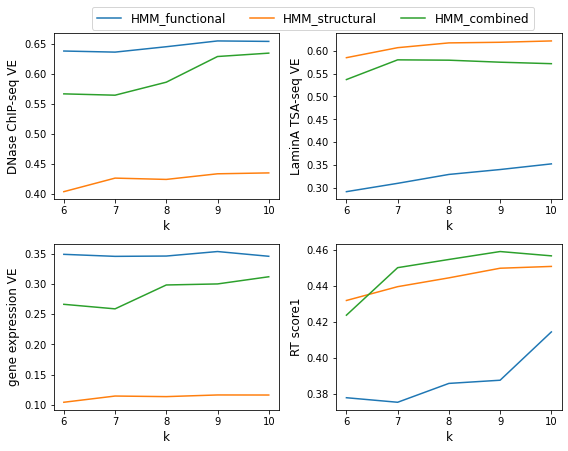

In [15]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

sns.lineplot(data = pd.DataFrame(VEs), x = 'k', y='DNase', hue = 'annot', ax = axs[0,0])
axs[0,0].set_ylabel('DNase ChIP-seq VE', size = 12)

sns.lineplot(data = pd.DataFrame(VEs), x = 'k', y='LaminA', hue = 'annot', ax = axs[0,1])
axs[0,1].set_ylabel('LaminA TSA-seq VE', size = 12)

sns.lineplot(data = pd.DataFrame(ge_VEs), x = 'k', y='ge_VE', hue = 'annot', ax = axs[1,0])
axs[1,0].set_ylabel('gene expression VE', size = 12)

sns.lineplot(data = pd.DataFrame(RT_scores), x = 'k', y='mean_VE', hue = 'annot', ax = axs[1,1])
axs[1,1].set_ylabel('RT score1', size = 12)

for i in [0,1]:
    for j in [0,1]:
        axs[i,j].set_xlabel('k', size = 12)
        axs[i,j].get_legend().remove()

        
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor = [0.55,1.05], ncol=3, fontsize = 12)
fig.tight_layout()

# enrichment plots

In [33]:
enrichments = {}
orders = {}
expr_stats = {}
coverages = {}
genes_nums = {}
SC_overlaps = {}
SC_pvalues = {}
GBR_overlaps = {}
GBR_pvalues = {}

k = 8

for input_type in ['functional', 'structural', 'combined']:
    path = "../../data/K562/hg19/res100000_datasets/annotations/k{}/HMM_{}_annotation.txt".format(k, input_type)
    enrichments['HMM_{}'.format(input_type)] = evaluation_utils.enrichment_scores_(signals_df, 
                                                                                   signals_names , 
                                                                                   'HMM_{}_k{}'.format(input_type, k))
    orders['HMM_{}'.format(input_type)] = np.argsort(enrichments['HMM_{}'.format(input_type)]['DNase'].values)




    expr_stats['HMM_{}'.format(input_type)] = evaluation_utils.gene_expr_stat(gene_expression_path, 
                                                                              path, 
                                                                              100000)
    coverages['HMM_{}'.format(input_type)] = evaluation_utils.coverage_stat(signals_df['HMM_{}_k{}'.format(input_type,k)])
    
    genes_nums['HMM_{}'.format(input_type)] = evaluation_utils.genes_num(gene_expression_path, path, 100000)
    fc, pval = evaluation_utils.overlap_fc(signals_df['HMM_{}_k{}'.format(input_type,k)],
                                                                            signals_df['SNIPER'])
    SC_overlaps['HMM_{}'.format(input_type)] = round(fc.iloc[:,orders['HMM_{}'.format(input_type)][::-1]],2).transpose()
    SC_pvalues['HMM_{}'.format(input_type)] = np.array(pval.iloc[:-1,orders['HMM_{}'.format(input_type)][::-1]]).transpose()
    
    fc, pval = evaluation_utils.overlap_fc(signals_df['HMM_{}_k{}'.format(input_type,k)],
                                                                            signals_df['segway_GBR'])
    GBR_overlaps['HMM_{}'.format(input_type)] = round(fc.iloc[:,orders['HMM_{}'.format(input_type)][::-1]],2).transpose()
    GBR_pvalues['HMM_{}'.format(input_type)] = np.array(pval.iloc[:,orders['HMM_{}'.format(input_type)][::-1]]).transpose()

In [20]:
orders['HMM_structural'] = [7, 6, 0, 4, 5, 2, 1, 3]

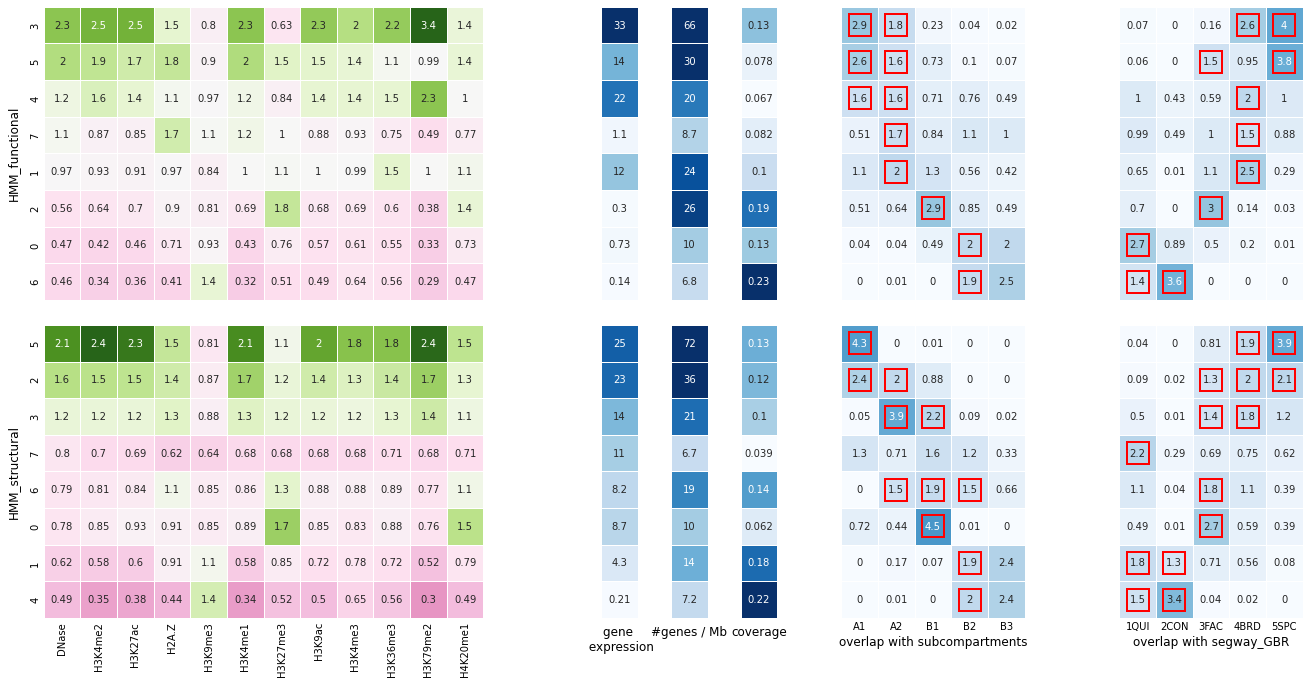

In [34]:
fig, axs = plt.subplots(2,6, figsize=(20,10), sharex = 'col', sharey = 'row',
                       gridspec_kw={'width_ratios': [12, 1, 1, 1, 5, 5],
                                   'height_ratios': [5,5]})

for m, method in enumerate(['HMM_functional', 'HMM_structural']):
    
    sns.heatmap(enrichments[method].iloc[orders[method][::-1],:], cmap="PiYG", center = 1, linewidths=.5, 
                square = True, cbar = False, annot = True, ax = axs[m,0])
    axs[m,0].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,0].set_yticklabels('')
    axs[m,0].set_ylabel(method, fontsize = 12, labelpad = 10)
    
    sns.heatmap(expr_stats[method].iloc[orders[method][::-1]], ax = axs[m,1], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 30)
    axs[m,1].set_ylabel('')
    axs[m,1].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,1].set_xticklabels([])
    
    sns.heatmap(genes_nums[method].iloc[orders[method][::-1]], ax = axs[m,2], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 28)
    axs[m,2].set_ylabel('')
    axs[m,2].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,2].set_xticklabels([])
    #axs[m,2].set_xlabel('#gene / Mb', fontsize = 12)
    

    sns.heatmap(coverages[method].iloc[orders[method][::-1]], ax = axs[m,3], cmap = 'Blues', annot = True, 
                cbar = False, square = True, linewidths=.5)
    axs[m,3].set_ylabel('')
    axs[m,3].tick_params(axis=u'both', which=u'both',length=0)
    axs[m,3].set_xticklabels([])
    
    sns.heatmap(SC_overlaps[method], ax = axs[m,4], 
            cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
    axs[m,4].set_xlabel('')
    axs[m,4].set_ylabel('')
    axs[m,4].tick_params(axis=u'both', which=u'both',length=0)
    for i in range(SC_pvalues[method].shape[0]):
        for j in range(SC_pvalues[method].shape[1]):
            if SC_pvalues[method][i,j] < 2.2e-16:
                axs[m,4].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
    
    sns.heatmap(GBR_overlaps[method], ax = axs[m,5], 
            cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
    axs[m,5].set_xlabel('')
    axs[m,5].set_ylabel('')
    axs[m,5].tick_params(axis=u'both', which=u'both',length=0)
    for i in range(GBR_pvalues[method].shape[0]):
        for j in range(GBR_pvalues[method].shape[1]):
            if GBR_pvalues[method][i,j] < 2.2e-16:
                axs[m,5].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
                
axs[1,1].set_xlabel('gene \n expression', fontsize = 12)
axs[1,2].set_xlabel('#genes / Mb', fontsize = 12)
axs[1,3].set_xlabel('coverage', fontsize = 12)
axs[1,4].set_xlabel('overlap with subcompartments', fontsize = 12)
axs[1,5].set_xlabel('overlap with segway_GBR', fontsize = 12)

fig.tight_layout(pad=2.5)

Text(0.5, 24.0, 'overlap with segway_GBR')

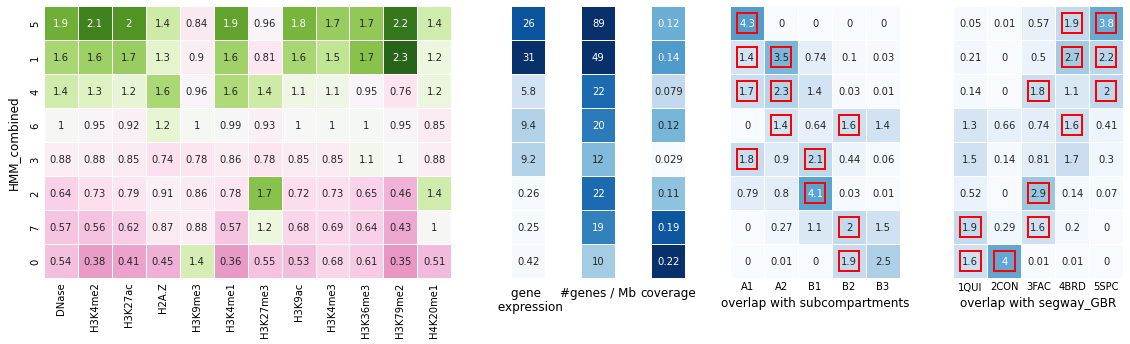

In [28]:
method = 'HMM_combined'
fig, axs = plt.subplots(1,6, figsize=(20,5), sharex = 'col', sharey = 'row',
                       gridspec_kw={'width_ratios': [12, 1, 1, 1, 5, 5],})
sns.heatmap(enrichments[method].iloc[orders[method][::-1],:], cmap="PiYG", center = 1, linewidths=.5, 
            square = True, cbar = False, annot = True, ax = axs[0])
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[0].set_yticklabels('')
axs[0].set_ylabel(method, fontsize = 12, labelpad = 10)

sns.heatmap(expr_stats[method].iloc[orders[method][::-1]], ax = axs[1], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 30)
axs[1].set_ylabel('')
axs[1].tick_params(axis=u'both', which=u'both',length=0)
axs[1].set_xticklabels([])
axs[1].set_xlabel('gene \n expression', fontsize = 12)

sns.heatmap(genes_nums[method].iloc[orders[method][::-1]], ax = axs[2], cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 28)
axs[2].set_ylabel('')
axs[2].tick_params(axis=u'both', which=u'both',length=0)
axs[2].set_xticklabels([])
axs[2].set_xlabel('#genes / Mb', fontsize = 12)
#axs[m,2].set_xlabel('#gene / Mb', fontsize = 12)


sns.heatmap(coverages[method].iloc[orders[method][::-1]], ax = axs[3], cmap = 'Blues', annot = True, 
            cbar = False, square = True, linewidths=.5)
axs[3].set_ylabel('')
axs[3].tick_params(axis=u'both', which=u'both',length=0)
axs[3].set_xticklabels([])
axs[3].set_xlabel('coverage', fontsize = 12)

sns.heatmap(SC_overlaps[method], ax = axs[4], 
        cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
axs[4].set_xlabel('')
axs[4].set_ylabel('')
axs[4].tick_params(axis=u'both', which=u'both',length=0)
for i in range(SC_pvalues[method].shape[0]):
    for j in range(SC_pvalues[method].shape[1]):
        if SC_pvalues[method][i,j] < 2.2e-16:
            axs[4].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
axs[4].set_xlabel('overlap with subcompartments', fontsize = 12)
    
sns.heatmap(GBR_overlaps[method], ax = axs[5], 
        cmap = 'Blues', annot = True, 
        cbar = False, square = True, linewidths=.5, vmin = 0, vmax = 7.5)
axs[5].set_xlabel('')
axs[5].set_ylabel('')
axs[5].tick_params(axis=u'both', which=u'both',length=0)
for i in range(GBR_pvalues[method].shape[0]):
    for j in range(GBR_pvalues[method].shape[1]):
        if GBR_pvalues[method][i,j] < 2.2e-16:
            axs[5].add_patch(Rectangle((j+0.2,i+0.2), 0.6, 0.6, ec='red', fc='none', lw=2))
axs[5].set_xlabel('overlap with segway_GBR', fontsize = 12)